<a href="https://colab.research.google.com/github/valdirdpg/curso-dnc/blob/master/Desafio%3DClassifica%C3%A7%C3%A3o_Cliente_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix




# **Carreegando e conhecendo os dados**

In [30]:
# Carregando o arquivo CSV
file_path = 'BankChurners.csv'
data = pd.read_csv(file_path)

# Exibindo as primeiras linhas do conjunto de dados para uma visão geral
data.head()


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [5]:
# Explorando a estrutura do conjunto de dados
# Verificando os tipos de dados e informações gerais
data_info = data.info()
data_description = data.describe(include='all')

# Verificando a presença de valores ausentes
missing_values = data.isnull().sum()

# Verificando dados duplicados
duplicates = data.duplicated().sum()

data_info, data_description, missing_values, duplicates


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

(None,
            CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
 count   1.012700e+04              10127  10127.000000  10127     10127.000000   
 unique           NaN                  2           NaN      2              NaN   
 top              NaN  Existing Customer           NaN      F              NaN   
 freq             NaN               8500           NaN   5358              NaN   
 mean    7.391776e+08                NaN     46.325960    NaN         2.346203   
 std     3.690378e+07                NaN      8.016814    NaN         1.298908   
 min     7.080821e+08                NaN     26.000000    NaN         0.000000   
 25%     7.130368e+08                NaN     41.000000    NaN         1.000000   
 50%     7.179264e+08                NaN     46.000000    NaN         2.000000   
 75%     7.731435e+08                NaN     52.000000    NaN         3.000000   
 max     8.283431e+08                NaN     73.000000    NaN         5.000000   
 
       

In [39]:
# Contar a frequência de cada tipo de cartão
frequencia_cartoes = data['Card_Category'].value_counts()

# Calcular o percentual de cada tipo de cartão
percentual_cartoes = (frequencia_cartoes / len(data)) * 100

print(percentual_cartoes.round(2))


Blue        93.18
Silver       5.48
Gold         1.15
Platinum     0.20
Name: Card_Category, dtype: float64


# **Análise Univariada**


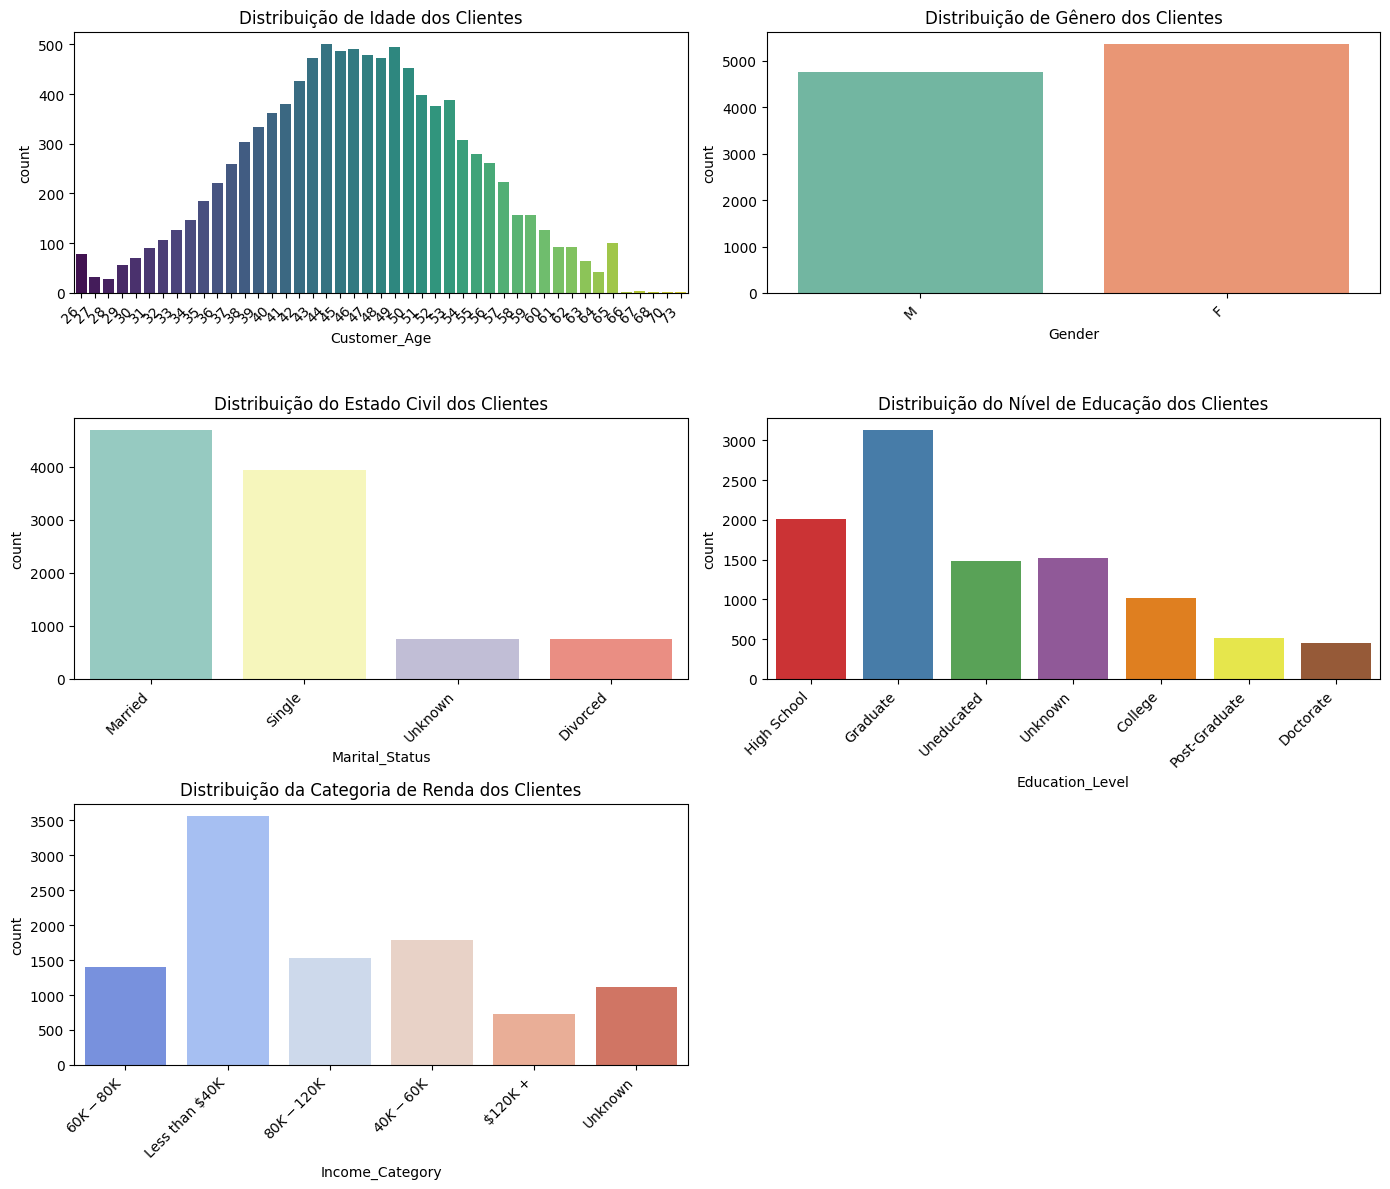

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

In [6]:
# Análise da Variável Alvo - Attrition_Flag
churn_distribution = data['Attrition_Flag'].value_counts()

# Análise Exploratória de Dados (EDA) - Visualizações Iniciais
# Visualização da distribuição de idade, gênero, estado civil, nível de educação, e categoria de renda
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
sns.countplot(ax=axes[0, 0], x='Customer_Age', data=data, palette='viridis')
sns.countplot(ax=axes[0, 1], x='Gender', data=data, palette='Set2')
sns.countplot(ax=axes[1, 0], x='Marital_Status', data=data, palette='Set3')
sns.countplot(ax=axes[1, 1], x='Education_Level', data=data, palette='Set1')
sns.countplot(ax=axes[2, 0], x='Income_Category', data=data, palette='coolwarm')
axes[2, 1].axis('off')  # Espaço vazio no layout do gráfico

# Ajustando os títulos e rotação dos eixos
axes[0, 0].set_title('Distribuição de Idade dos Clientes')
axes[0, 1].set_title('Distribuição de Gênero dos Clientes')
axes[1, 0].set_title('Distribuição do Estado Civil dos Clientes')
axes[1, 1].set_title('Distribuição do Nível de Educação dos Clientes')
axes[2, 0].set_title('Distribuição da Categoria de Renda dos Clientes')
for ax in axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

churn_distribution


# **Análise Bivariada**

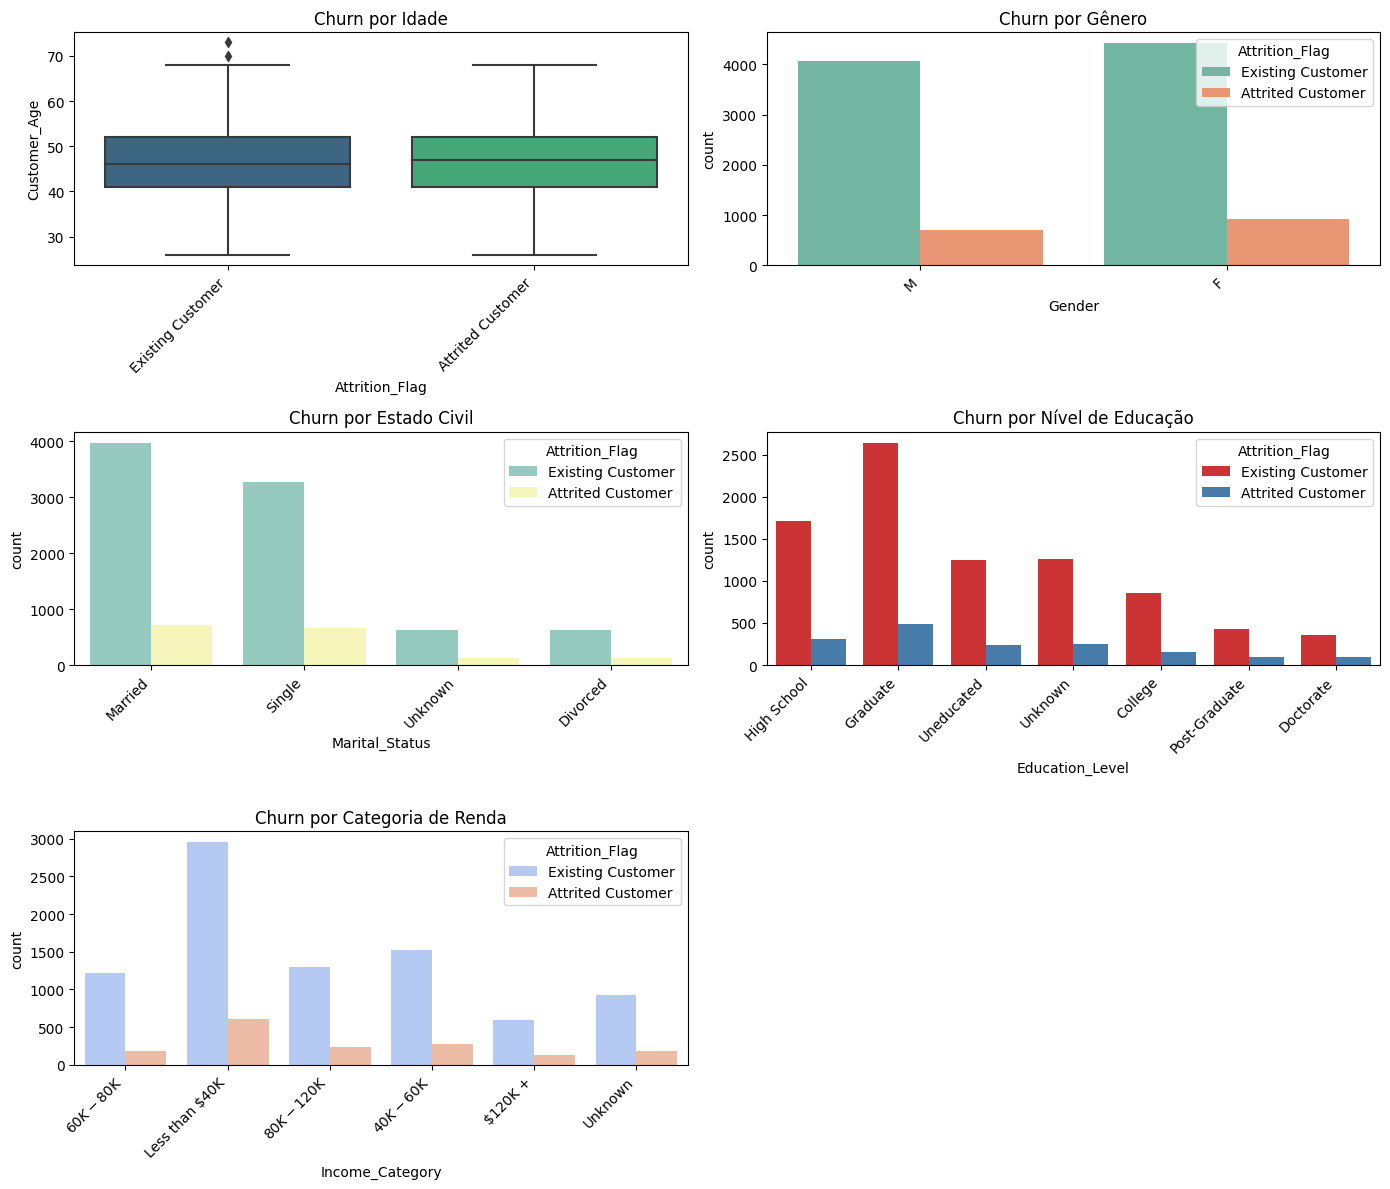

In [7]:
# Análise Bivariada - Comparando variáveis com a Attrition_Flag
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Comparando Idade com Churn
sns.boxplot(ax=axes[0, 0], x='Attrition_Flag', y='Customer_Age', data=data, palette='viridis')

# Comparando Gênero com Churn
sns.countplot(ax=axes[0, 1], x='Gender', hue='Attrition_Flag', data=data, palette='Set2')

# Comparando Estado Civil com Churn
sns.countplot(ax=axes[1, 0], x='Marital_Status', hue='Attrition_Flag', data=data, palette='Set3')

# Comparando Nível de Educação com Churn
sns.countplot(ax=axes[1, 1], x='Education_Level', hue='Attrition_Flag', data=data, palette='Set1')

# Comparando Categoria de Renda com Churn
sns.countplot(ax=axes[2, 0], x='Income_Category', hue='Attrition_Flag', data=data, palette='coolwarm')

axes[2, 1].axis('off')  # Espaço vazio no layout do gráfico

# Ajustando os títulos e a rotação dos eixos
axes[0, 0].set_title('Churn por Idade')
axes[0, 1].set_title('Churn por Gênero')
axes[1, 0].set_title('Churn por Estado Civil')
axes[1, 1].set_title('Churn por Nível de Educação')
axes[2, 0].set_title('Churn por Categoria de Renda')
for ax in axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()




1.   A distribuição de idade entre os clientes que permaneceram e os que saíram parece ser relativamente semelhante, com uma ligeira tendência de churn entre clientes mais jovens.

2.   O churn parece ser um pouco mais prevalente entre um dos gêneros, embora a diferença não seja muito pronunciada.

3.  Existem diferenças notáveis na taxa de churn entre diferentes estados civis, com algumas categorias mostrando maior propensão ao churn.

4.  O churn varia entre diferentes níveis de educação, indicando que a educação pode ter um impacto na decisão de permanecer ou sair do banco.

5.  As taxas de churn parecem variar entre as diferentes categorias de renda, com algumas categorias mostrando maior propensão ao churn.



# **Pré-processamento de dados**

In [8]:
# Função para realizar o teste Qui-quadrado para variáveis categóricas
def chi_square_test(data, column, target):
    contingency_table = pd.crosstab(data[column], data[target])
    _, p, _, _ = chi2_contingency(contingency_table)
    return p

# Variáveis categóricas para o teste
categorical_vars = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

# Realizando o teste Qui-quadrado para cada variável categórica
chi_square_results = {var: chi_square_test(data, var, 'Attrition_Flag') for var in categorical_vars}

# Teste t de Student para variáveis numéricas
from scipy.stats import ttest_ind

# Variáveis numéricas para teste
numerical_vars = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
                  'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
                  'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
                  'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

# Realizando o teste t de Student
t_test_results = {}
for var in numerical_vars:
    group1 = data[data['Attrition_Flag'] == 'Existing Customer'][var]
    group2 = data[data['Attrition_Flag'] == 'Attrited Customer'][var]
    t_test_results[var] = ttest_ind(group1, group2).pvalue

chi_square_results, t_test_results


({'Gender': 0.00019635846717310307,
  'Education_Level': 0.05148913147336634,
  'Marital_Status': 0.10891263394840227,
  'Income_Category': 0.025002425704390617,
  'Card_Category': 0.5252382797994759},
 {'Customer_Age': 0.06698688501759036,
  'Dependent_count': 0.05600239253509303,
  'Months_on_book': 0.16843702876495353,
  'Total_Relationship_Count': 4.829281002184844e-52,
  'Months_Inactive_12_mon': 1.0326639995929033e-53,
  'Contacts_Count_12_mon': 4.6974896307500795e-96,
  'Credit_Limit': 0.016285357205394337,
  'Total_Revolving_Bal': 6.630148455415696e-160,
  'Avg_Open_To_Buy': 0.9771160894458855,
  'Total_Amt_Chng_Q4_Q1': 4.836642703584486e-40,
  'Total_Trans_Amt': 1.857438655660998e-65,
  'Total_Trans_Ct': 0.0,
  'Total_Ct_Chng_Q4_Q1': 1.6477247846935743e-195,
  'Avg_Utilization_Ratio': 3.357689328246027e-73})

# Resultados do Teste Qui-quadrado (para variáveis categóricas)

Gênero: p-valor = 0.0002, indica uma associação estatisticamente significativa com o churn.
Nível de Educação: p-valor = 0.051, sugere uma possível, mas não forte, associação com o churn.
Estado Civil: p-valor = 0.109, não mostrando uma associação forte com o churn.
Categoria de Renda: p-valor = 0.025, indica uma associação significativa com o churn.
Categoria do Cartão: p-valor = 0.525, não mostrando uma associação significativa com o churn.

# Resultados do Teste t de Student (para variáveis numéricas):
Idade do Cliente, Contagem de Dependentes, e Meses na Conta: p-valores ligeiramente acima de 0.05, indicando uma associação fraca ou nenhuma com o churn.
Total de Relacionamentos com o Banco, Meses Inativos nos Últimos 12 Meses, Contatos nos Últimos 12 Meses, Limite de Crédito, Saldo Rotativo Total, Mudança no Valor Total entre o 4º e o 1º Trimestre, Valor Total das Transações, Contagem Total de Transações e Mudança na Contagem Total de Transações entre o 4º e o 1º Trimestre: Todos com p-valores extremamente baixos, indicando uma associação muito forte com o churn.
Crédito Médio Disponível para Compra: p-valor próximo de 1, não mostrando uma associação significativa com o churn.

# Criação, Treinamento e Avaliação do Modelo

In [9]:
# Pré-processamento: Codificação de variáveis categóricas
label_encoders = {}
for column in categorical_vars:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Codificando a variável alvo
le_attrition_flag = LabelEncoder()
data['Attrition_Flag'] = le_attrition_flag.fit_transform(data['Attrition_Flag'])

# Divisão dos dados em conjuntos de treino e teste
X = data.drop(['Attrition_Flag', 'CLIENTNUM'], axis=1)  # Excluindo a variável alvo e o identificador do cliente
y = data['Attrition_Flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [10]:
# Aplicando SMOTE novamente para equilibrar as classes
try:
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Verificando o balanceamento das classes após a aplicação do SMOTE
    class_distribution_smote = pd.Series(y_train_smote).value_counts()

    # Treinando o modelo de Random Forest novamente com os dados balanceados
    rf_classifier_smote = RandomForestClassifier(random_state=42)
    rf_classifier_smote.fit(X_train_smote, y_train_smote)

    # Avaliação da Importância das Variáveis com os dados balanceados
    feature_importances_smote = pd.Series(rf_classifier_smote.feature_importances_, index=X.columns).sort_values(ascending=False)

    success = True
except Exception as e:
    success = False
    error_message = str(e)


success, class_distribution_smote if success else error_message, feature_importances_smote if success else None




(True,
 1    5957
 0    5957
 Name: Attrition_Flag, dtype: int64,
 Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1    0.378022
 Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2    0.352437
 Total_Trans_Ct                                                                                                                        0.081460
 Total_Trans_Amt                                                                                                                       0.067797
 Total_Revolving_Bal                                                                                                                   0.033906
 Total_Ct_Chng_Q4_Q1                                                                                                                   0.029166
 Avg_Utilization_Ratio                                                

In [11]:
# Treinamento e Avaliação
# Configuração dos classificadores
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

for name, clf in classifiers.items():
    clf.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test)
    print(f"---{name}---")
    print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


---Logistic Regression---
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       496
           1       0.98      0.94      0.96      2543

    accuracy                           0.94      3039
   macro avg       0.87      0.93      0.90      3039
weighted avg       0.95      0.94      0.94      3039

---Random Forest---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       1.00      1.00      1.00      2543

    accuracy                           1.00      3039
   macro avg       1.00      1.00      1.00      3039
weighted avg       1.00      1.00      1.00      3039

---Gradient Boosting---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       1.00      1.00      1.00      2543

    accuracy                           1.00      3039
   macro avg       1.00      1.00      1.00      3039
weig

In [12]:
# 'y_pred' são as previsões e 'y_test' são as etiquetas verdadeiras
# Após verificar os modelos de classificação, percebo que LogistcRegression() tem um melhor desempenho em modo geral
# Treinamento e previsão com Logistic Regression
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_smote, y_train_smote)
y_pred = logistic_regression_model.predict(X_test)

acuracia = accuracy_score(y_test, y_pred)
precisao = precision_score(y_test, y_pred)
revocacao = recall_score(y_test, y_pred)
pontuacao_f1 = f1_score(y_test, y_pred)

print(f"Acurácia: {acuracia}")
print(f"Precisão: {precisao}")
print(f"Revocação: {revocacao}")
print(f"Pontuação F1: {pontuacao_f1}")

Acurácia: 0.9387956564659428
Precisão: 0.9820040899795501
Revocação: 0.9441604404246953
Pontuação F1: 0.9627105052125101


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
# Criando a matriz de confusão para Logistic Regression
y_pred_logistic_regression = logistic_regression_model.predict(X_test)

conf_matrix_logistic_regression = confusion_matrix(y_test, y_pred_logistic_regression)

print("---Matriz de Confusão: Logistic Regression---")
print(conf_matrix_logistic_regression)


---Matriz de Confusão: Logistic Regression---
[[ 452   44]
 [ 142 2401]]


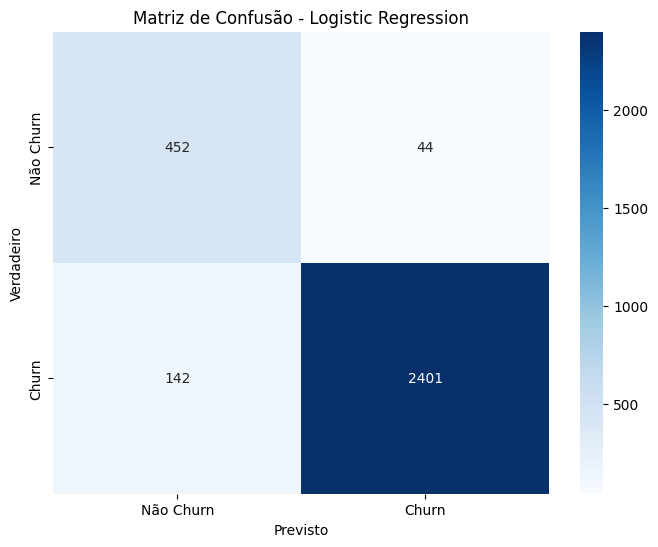

In [16]:
# Cofigurando a matriz de confusão com HeatMap
conf_matrix = np.array([[452, 44], [142, 2401]])

# Criando o gráfico de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não Churn", "Churn"],
            yticklabels=["Não Churn", "Churn"])
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão - Logistic Regression')
plt.show()


Verdadeiros Negativos (VN): 452 - O modelo previu corretamente 452 casos como não churn. \
Falsos Positivos (FP): 44 - O modelo previu incorretamente 44 casos como Churn, mas na realidade, eram Não Churn. \
Falsos Negativos (FN): 142 - O modelo  falhou em prever não churn quando realmente havia Churn. \
Verdadeiros Positivos (VP): 2401 - O modelo previu corretamente 2401 casos de churn.

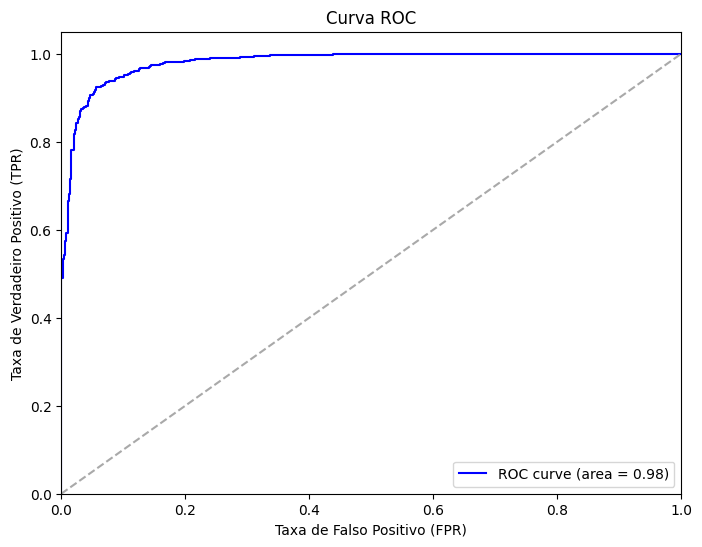

In [17]:
# Probabilidades de previsão para a classe positiva
y_pred_prob = logistic_regression_model.predict_proba(X_test)[:, 1]

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculando a AUC
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


### A curva rock aponta que o modelo foi bem construido, já que a grosso moddo pode se dizer que um modelo bem construido a curva roc aponto para o canto superior esquerdo do quadro. Não fiz a curva para o modelo de Random Forest.

In [18]:
# Treinamento do modelo de Regressão Logística
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_smote, y_train_smote)

# Coeficientes do modelo
coeficientes = logistic_regression_model.coef_[0]

# Criando um DataFrame para visualizar a importância das características
features = pd.DataFrame()
features['Característica'] = X_train.columns
features['Importância'] = coeficientes
features = features.sort_values(by=['Importância'], ascending=False)



features


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Característica,Importância
20,Naive_Bayes_Classifier_Attrition_Flag_Card_Cat...,2.392619
8,Total_Relationship_Count,1.466106
1,Gender,0.556835
17,Total_Ct_Chng_Q4_Q1,0.223277
12,Total_Revolving_Bal,0.183181
13,Avg_Open_To_Buy,0.182318
16,Total_Trans_Ct,0.131048
4,Marital_Status,0.063531
6,Card_Category,0.045722
7,Months_on_book,0.007552


#### Modelo de Regressão Linear não possui atributo de importância de caracterísca direta, não que eu tenha encontrado, desta forma, dai observei o coeficiente do modelo, sei que quanto mais alto for o coeficiente, positiva ou negativamente, mais importante ele é.

# Comparando Random Forest com o resultado do Logístic Regression

In [13]:
# Treinamento do Modelo de Random Forest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Avaliação da Importância das Variáveis
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns).sort_values(ascending=False)

feature_importances

Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2    0.420454
Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1    0.377210
Total_Trans_Ct                                                                                                                        0.050011
Total_Trans_Amt                                                                                                                       0.039081
Total_Ct_Chng_Q4_Q1                                                                                                                   0.034222
Total_Revolving_Bal                                                                                                                   0.026564
Avg_Utilization_Ratio                                                                                                                 0.020026

In [15]:
# para fins de comparação fiz uma matriz de confusão para  o modelo Random Forest
y_pred_random_forest = rf_classifier.predict(X_test)
conf_matrix_rf = confusion_matrix(y_test,y_pred_random_forest)
print("---Matriz de Confusão: Random Forest---")
print(conf_matrix_rf)

---Matriz de Confusão: Random Forest---
[[ 496    0]
 [   0 2543]]


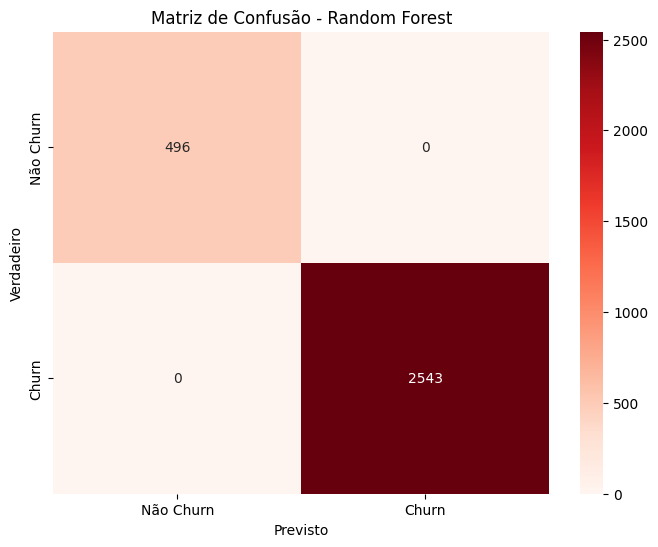

In [20]:
# Cofigurando a matriz de confusão com HeatMap
conf_matrix = np.array([[496, 0], [0, 2543]])

# Criando o gráfico de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Não Churn", "Churn"],
            yticklabels=["Não Churn", "Churn"])
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão - Random Forest')
plt.show()
